# Comparing the top KEGGs and species in ratio plots



In [1]:
import pandas as pd
import numpy as np


import itertools
from sklearn.linear_model import LogisticRegressionCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import BaggingClassifier

from collections import Counter

import matplotlib.pylab as plt
import seaborn as sns;
%matplotlib inline

## Data prep

Load KEGGs and species data. Filter out species data to only have subjects that are present in the KEGGs data.

In [201]:
df_keggs = pd.read_csv("../../data/keggs-subjects-rf-scores.csv")

df_keggs.head()

,kegg,over.abundant.health.conf,LS001,LS002,LS003,LS004,LS005,LS006,LS007,CD.SRS301865,...,HE.SRS016335,HE.SRS016495,HE.SRS017103,HE.SRS017433,HE.SRS018427,HE.SRS018656,HE.SRS020328,HE.SRS020869,HE.SRS022713,HE.SRS016585.suspect
0,K00001(alcohol_dehydrogenase),0.366,0.005732,0.006140,0.006243,0.005962,0.008011,0.004744,0.005444,0.005043,...,0.002705,0.005025,0.003359,0.004281,0.003052,0.003625,0.002673,0.003999,0.003734,8.220359e-03
1,K00002(alcohol_dehydrogenase_(NADP+)),0.312,0.000382,0.000409,0.000610,0.000533,0.000313,0.000412,0.000390,0.001005,...,0.000461,0.000255,0.000071,0.000014,0.000248,0.000649,0.000151,0.000157,0.000000,4.812945e-07
2,K00003(homoserine_dehydrogenase),0.310,0.000855,0.001034,0.001125,0.001074,0.001224,0.000721,0.000786,0.001025,...,0.000195,0.001063,0.000249,0.000131,0.000351,0.000676,0.000430,0.000318,0.000050,1.209999e-06
3,"K00004((R,R)-butanediol_dehydrogenase_/_diacet...",0.192,0.000091,0.000106,0.000149,0.000116,0.000064,0.000084,0.000080,0.000016,...,0.000006,0.000025,0.000008,0.000008,0.000014,0.000039,0.000068,0.000010,0.000006,4.127393e-04
4,K00005(glycerol_dehydrogenase),0.004,0.000167,0.000236,0.000223,0.000203,0.000218,0.000144,0.000143,0.000166,...,0.000012,0.000427,0.000030,0.000004,0.000034,0.000036,0.000055,0.000065,0.000000,2.158647e-04


In [3]:
df_species = pd.read_csv("../../data/species/processedData/ref_cov_abundance-clean/ref_species_cov_abundance.txt-Table 1.csv")

df_species.head()

,taxid,desc,superkingdom,phylum,class,order,family,genus,species,LS001,...,HE-SRS101433,HE-SRS103987,HE-SRS104197,HE-SRS104311,HE-SRS104400,HE-SRS104485,HE-SRS105082,HE-SRS105153,HE-SRS140492,HE-SRS140513
0,2173,Methanobrevibacter smithii,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter smithii,0.184008,...,0.000000,0.000000,0.000000,0.000453,0.002667,0.000000,0.000000,0.000000,0.00000,0.000000
1,33033,Parvimonas micra,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiales Family XI. Incertae Sedis,Parvimonas,Parvimonas micra,0.159721,...,0.000013,0.000000,0.000000,0.000029,0.000017,0.000000,0.000000,0.000000,0.00000,0.000016
2,562,Escherichia coli,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Escherichia,Escherichia coli,0.103199,...,0.000840,0.000076,0.000042,0.000222,0.000485,0.000031,0.002437,0.000048,0.00574,0.002419
3,341694,Peptostreptococcus stomatis,Bacteria,Firmicutes,Clostridia,Clostridiales,Peptostreptococcaceae,Peptostreptococcus,Peptostreptococcus stomatis,0.062615,...,0.000000,0.000000,0.000000,0.000000,0.000017,0.000000,0.000000,0.000000,0.00001,0.000000
4,457404,Fusobacterium sp. 12_1B,Bacteria,Fusobacteria,Fusobacteriia,Fusobacteriales,Fusobacteriaceae,Fusobacterium,Fusobacterium sp. 12_1B,0.055544,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


In [4]:
df_species.iloc[:,9:].head()

,LS001,LS002,LS003,LS004,LS005,LS006,LS007,CD-58-Time1,CD-58-Time2,CD-58-Time3,...,HE-SRS101433,HE-SRS103987,HE-SRS104197,HE-SRS104311,HE-SRS104400,HE-SRS104485,HE-SRS105082,HE-SRS105153,HE-SRS140492,HE-SRS140513
0,0.184008,0.003628,0.003694,0.038584,0.031065,0.070370,0.035170,0.000000,0.000010,0.000000,...,0.000000,0.000000,0.000000,0.000453,0.002667,0.000000,0.000000,0.000000,0.00000,0.000000
1,0.159721,0.000073,0.000048,0.000263,0.000210,0.001110,0.001093,0.000011,0.000000,0.000269,...,0.000013,0.000000,0.000000,0.000029,0.000017,0.000000,0.000000,0.000000,0.00000,0.000016
2,0.103199,0.099081,0.096903,0.065271,0.001651,0.029671,0.002061,0.009693,0.004983,0.000186,...,0.000840,0.000076,0.000042,0.000222,0.000485,0.000031,0.002437,0.000048,0.00574,0.002419
3,0.062615,0.000057,0.000054,0.000208,0.000114,0.000150,0.000415,0.000000,0.000000,0.000052,...,0.000000,0.000000,0.000000,0.000000,0.000017,0.000000,0.000000,0.000000,0.00001,0.000000
4,0.055544,0.000021,0.000024,0.000082,0.000024,0.016889,0.000035,0.000000,0.000000,0.000011,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


In [5]:
df_species.columns = df_species.columns.str.replace('-','.')

In [6]:
HE_in_keggs_data = list(df_keggs.columns[30:])

In [7]:
HE_in_keggs_data

['HE.SRS011061',
 'HE.SRS011084',
 'HE.SRS011134',
 'HE.SRS011239',
 'HE.SRS011271',
 'HE.SRS011302',
 'HE.SRS011405',
 'HE.SRS011452',
 'HE.SRS011529',
 'HE.SRS011586',
 'HE.SRS012273',
 'HE.SRS012902',
 'HE.SRS013158',
 'HE.SRS013215',
 'HE.SRS013687',
 'HE.SRS013951',
 'HE.SRS014235',
 'HE.SRS014923',
 'HE.SRS014979',
 'HE.SRS015065',
 'HE.SRS015217',
 'HE.SRS015578',
 'HE.SRS015663',
 'HE.SRS016018',
 'HE.SRS016095',
 'HE.SRS016335',
 'HE.SRS016495',
 'HE.SRS017103',
 'HE.SRS017433',
 'HE.SRS018427',
 'HE.SRS018656',
 'HE.SRS020328',
 'HE.SRS020869',
 'HE.SRS022713',
 'HE.SRS016585.suspect']

In [8]:
HE_in_keggs_data[-1] = 'HE.SRS016585'

In [9]:
df_species = pd.concat([df_species.iloc[:,:37], df_species[HE_in_keggs_data]], axis = 1)

species_names = df_species.iloc[:,2:9].apply(lambda x: "{0}-{1}-{2}-{3}-{4}-{5}-{6}".format(*x.values), axis = 1)

df_species.index = species_names

In [10]:
df_species.shape

(2572, 72)

In [11]:
df_keggs.shape

(10012, 65)

## Helper functions


In [12]:
class RatioComputer():
    ''' Compute average ratios between three different cohorts (UC, CD, LS) 
    against HE. Compute the condition number 
    
    
    Args:
    -----
    df_subjects : pandas data frame
        Data frame where we expect rows to be KEGGs with columns corresponding 
        to the cohorts HE, LS, CD, and UC. We expect the strings "HE", "LS", 
        "CD", and "UC" to be in the  header names.

    laplace_scale : float (default 1e-9)
        What value to add to ALL KEGGs to avoid division by 0 and log(0) 
        issues.
    
    random_cohort : binary (default False)
        Whether the cohorts should be randomized. Useful for hypothesis 
        testing. If random cohorts are used, then 35, 6, 7, and 15 columns are 
        randomly sampled without replacement correspondings to the cohorts HE, 
        LS, UC, and CD respectively. Thesenumbers reflect the sample sizes for 
        each cohort. 
        
    
    Attributes:
    -----------
    HE_df, LS_df, UC_df, CD_df : pandas data frames
        Pandas datafames corresponding to subject samples used for HE, LS, UC, 
        and CD cohorts.
        
    df_subjects : pandas data frame
        Subjects data frame passed that remains untouched even when 
        random_cohort = True
    
    random_cohort : binary (default True)
        If random samples where used to create HE_df, LS_df, UC_df, and CD_df. 
        
        
    Example:
    --------
    >>> # read data
    >>> df = pd.read_csv("../data/keggs-subjects-rf-scores.csv")
    >>> mean_ratios = RatioComputer(df_subjects = df.iloc[:,2:])
    >>> mean_ratios.mean_ratios_cond_number(laplace_scale_numerator=False)

    
    '''
    def __init__(self, df_subjects, laplace_scale = 1e-9,
                 random_cohort = False):
        self.df_subjects = df_subjects
        self.random_cohort = random_cohort
        self.laplace_scale = laplace_scale
        
        if self.random_cohort:
            df_random = df_subjects.iloc[:,np.random.permutation(np.arange(df_subjects.shape[1]))]
            self.HE_df = df_random.iloc[:,:35]
            self.LS_df = df_random.iloc[:,35:(35+7)]
            self.UC_df = df_random.iloc[:,(35+7):(35+7+6)]
            self.CD_df = df_random.iloc[:,(35+7+6):]
            
        else:
            self.HE_df = df_subjects.filter(regex=("HE.*"))
            self.LS_df = df_subjects.filter(regex=("LS.*"))
            self.UC_df = df_subjects.filter(regex=("UC.*"))
            self.CD_df = df_subjects.filter(regex=("CD.*"))
            

            
    def return_eig_vals(self):
        self.ratio_matrix_finite = self.ratio_matrix[:,np.all(np.isfinite(self.ratio_matrix), 
                                                              axis=0)]      
        self.ratio_matrix_cov = np.cov(self.ratio_matrix_finite)
        w, v = np.linalg.eig(self.ratio_matrix_cov)  
        return w    
    
    
    def mean_ratios_cond_number(self, normalize = False, 
                                laplace_scale_numerator = True):
        ''' compute mean KEGG for each KEGG for each cohort, then take the 
        log-ratio of the average KEGG for cohorts LS, CD, and UC against HE to 
        yeild the tuple (LS/HE, UC/HE, CD/HE). Can think of this tuple as a 
        matrix with 3 columns corresponding to the 3 ratios and ~10K rows 
        corresponding to each KEGG. We compute the condition number for 3x3 
        covariance matrix formed by this tuple. 
        
        
        Args:
        -----
        normalize : binary (default False)
            Whether the *averaged* relative abundances should be normalized 
            so that  all KEGGs add to 1.0 after averaging has been computed. 
        
        laplace_scale_numerator : binary (default True)
            Whether the numerator of the ratio should also be laplaced scale 
            in addition to the denominator. When laplace_scale_numerator=True
            the ratios are computed as:
            
                        a_b = np.log10((a + laplace_scale)/(b + laplace_scale)
            
            This handles division by 0 errors (when b = 0) and log(0) errors 
            (when a = 0). If laplace_scale_numerator=False, then the ratios 
            are computed as:
                       
                       a_b = np.log10(a/(b + laplace_scale) 
            
            In other words, NaNs will be introduced for cases when a = 0 since
            np.log10(0) is -inf
        
        '''
                    
        with np.errstate(divide='ignore'):
            self.HE_mean = self.HE_df.apply(lambda x: 10**np.nanmean(np.log10(x)), 
                                       axis = 1)
            self.LS_mean = self.LS_df.apply(lambda x: 10**np.nanmean(np.log10(x)), 
                                       axis = 1)
            self.UC_mean = self.UC_df.apply(lambda x: 10**np.nanmean(np.log10(x)), 
                                       axis = 1)
            self.CD_mean = self.CD_df.apply(lambda x: 10**np.nanmean(np.log10(x)), 
                                       axis = 1)
        
        if normalize:
            self.HE_mean = self.HE_mean/np.nansum(self.HE_mean)
            self.LS_mean = self.LS_mean/np.nansum(self.LS_mean)
            self.CD_mean = self.CD_mean/np.nansum(self.CD_mean)
            self.UC_mean = self.UC_mean/np.nansum(self.UC_mean)
            
        if laplace_scale_numerator:    
            self.LS_HE_mean = np.log10((self.LS_mean+self.laplace_scale)/(self.HE_mean+self.laplace_scale))
            self.UC_HE_mean = np.log10((self.UC_mean+self.laplace_scale)/(self.HE_mean+self.laplace_scale))
            self.CD_HE_mean = np.log10((self.CD_mean+self.laplace_scale)/(self.HE_mean+self.laplace_scale))
        else:
            with np.errstate(divide='ignore'):
                self.LS_HE_mean = np.log10((self.LS_mean)/(self.HE_mean+self.laplace_scale))
                self.UC_HE_mean = np.log10((self.UC_mean)/(self.HE_mean+self.laplace_scale))
                self.CD_HE_mean = np.log10((self.CD_mean)/(self.HE_mean+self.laplace_scale))
            
        self.ratio_matrix = np.array([self.LS_HE_mean, self.UC_HE_mean, self.CD_HE_mean])
        
        w = self.return_eig_vals()
        self.cond_number = np.max(w)/np.min(w) 
        return self.cond_number   

    def median_ratios_cond_number(self, laplace_scale = 1e-9, normalize = False, laplace_scale_numerator = True):
        HE_median = self.HE_df.apply(lambda x: np.median(x), axis = 1)
        LS_median = self.LS_df.apply(lambda x: np.median(x), axis = 1)
        UC_median = self.UC_df.apply(lambda x: np.median(x), axis = 1)
        CD_median = self.CD_df.apply(lambda x: np.median(x), axis = 1)
        
        if normalize:
            HE_median = HE_median/np.sum(HE_median)
            LS_median = LS_median/np.sum(LS_median)
            CD_median = CD_median/np.sum(CD_median)
            UC_median = UC_median/np.sum(UC_median)
        
        if laplace_scale_numerator:
            self.LS_HE_median = np.log10((LS_median+self.laplace_scale)/(HE_median+self.laplace_scale))
            self.UC_HE_median = np.log10((UC_median+self.laplace_scale)/(HE_median+self.laplace_scale))
            self.CD_HE_median = np.log10((CD_median+self.laplace_scale)/(HE_median+self.laplace_scale))
        else:
            with np.errstate(divide='ignore'):
                self.LS_HE_median = np.log10((LS_median)/(HE_median+self.laplace_scale))
                self.UC_HE_median = np.log10((UC_median)/(HE_median+self.laplace_scale))
                self.CD_HE_median = np.log10((CD_median)/(HE_median+self.laplace_scale))            
            
        self.ratio_matrix = np.array([self.LS_HE_median, self.UC_HE_median, self.CD_HE_median])  
        
        w = self.return_eig_vals()
        self.cond_number = np.max(w)/np.min(w)  
        return self.cond_number
    
    def plot_mean_ratios(self):
        plt.subplot(1,3,1)
        plt.plot(self.LS_HE_mean, self.CD_HE_mean, '.')
        plt.xlabel("LS to HE")
        plt.ylabel("CD to HE")

        plt.subplot(1,3,2)
        plt.plot(self.LS_HE_mean, self.UC_HE_mean, '.')
        plt.xlabel("LS to HE")
        plt.ylabel("UC to HE")
        
        plt.subplot(1,3,3)
        plt.plot(self.UC_HE_mean, self.CD_HE_mean, '.')
        plt.xlabel("UC to HE")
        plt.ylabel("CD to HE")
        
        
    def plot_median_ratios(self):
        plt.subplot(1,3,1)
        plt.plot(self.LS_HE_median, self.CD_HE_median, '.')
        plt.xlabel("LS to HE")
        plt.ylabel("CD to HE")

        plt.subplot(1,3,2)
        plt.plot(self.LS_HE_median, self.UC_HE_median, '.')
        plt.xlabel("LS to HE")
        plt.ylabel("UC to HE")
        
        plt.subplot(1,3,3)
        plt.plot(self.UC_HE_median, self.CD_HE_median, '.')
        plt.xlabel("UC to HE")
        plt.ylabel("CD to HE")

In [13]:
def pairwise_diffs(np_arr):
    pairwise_indexes = list(itertools.combinations(list(range(np_arr.shape[0])), 2))    
    np_diffs = np.array([np.abs(np_arr[i,:] - np_arr[j,:]) for i, j in pairwise_indexes])
    return np_diffs

def get_sparse_set(input_arr, target_arr, laplace_scale):
    X_diffs = pairwise_diffs(np.log10(input_arr + laplace_scale))

    y_diffs = pairwise_diffs(target_arr[:, np.newaxis]).squeeze()
    y_diffs[y_diffs != 0] = 1
    
    LR = LogisticRegressionCV(Cs = np.logspace(-4, 2, 25), penalty="l1",
                              n_jobs=-2, solver = "liblinear")

    LR.fit(X_diffs, y_diffs)
    
    return LR


class PairwiseLR(BaseEstimator, ClassifierMixin):  
    def __init__(self, laplace_scale, **kwargs):
        self.laplace_scale = laplace_scale
        self.LR = LogisticRegressionCV(Cs = np.logspace(-4, -2, 10), penalty="l1",
                                       n_jobs=1, solver = "liblinear")
    
    def _pairwise_diffs(self, np_arr):
        pairwise_indexes = list(itertools.combinations(list(range(np_arr.shape[0])), 2))    
        np_diffs = np.array([np.abs(np_arr[i,:] - np_arr[j,:]) for i, j in pairwise_indexes])
        return np_diffs

    def fit(self, X, y):
        X_diffs = self._pairwise_diffs(np.log10(X + self.laplace_scale))

        y_diffs = self._pairwise_diffs(y[:, np.newaxis]).squeeze()
        y_diffs[y_diffs != 0] = 1        
        
        
        self.LR.fit(X_diffs, y_diffs)
        
        return self

    def predict(self, X, y=None):
        X_diffs = self._pairwise_diffs(np.log10(X + self.laplace_scale))
        return self.LR.predict(X_diffs)


## Species Pairwise Logistic Regression

We next prepare the data so that they are pairwise comparisons of each sample and apply lass logistic regression to find the most important **species** that discriminate that either the samples are in the same cohort or not. We again use cross validation to select the penalty term. We select the important species as those that have a positive weight.

In [15]:
X_species = df_species.iloc[:,9:].values.T

y_species = np.zeros(X_species.shape[0]) # 0 is healthy

y_species[np.where(df_species.iloc[:, 9:].columns.str.contains("LS"))[0]] = 1 # 1 is LS
y_species[np.where(df_species.iloc[:, 9:].columns.str.contains("CD"))[0]] = 2 # 2 is CD
y_species[np.where(df_species.iloc[:, 9:].columns.str.contains("UC"))[0]] = 3 # 3 is UC

In [16]:
X_species[X_species>0].min()

1.0000000000000001e-05

In [17]:
laplace_scale = 1e-6

In [18]:
clf = PairwiseLR(laplace_scale)

bg = BaggingClassifier(clf, 
                       bootstrap = True,
                       n_estimators=1000, 
                       n_jobs=-2, 
                       max_samples = 1.0)

In [19]:
%%time
bg.fit(X_species, y_species)

CPU times: user 1.52 s, sys: 1.14 s, total: 2.66 s
Wall time: 4min 29s


BaggingClassifier(base_estimator=PairwiseLR(laplace_scale=1e-06),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=1000, n_jobs=-2, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [20]:
collection_of_species = []
for estimator in bg.estimators_:
    collection_of_species.append(np.where(estimator.LR.coef_.squeeze() >0)[0])

In [21]:
collection_of_species_list = [specie for species in collection_of_species for specie in species]

specie_frequency_counts = Counter(collection_of_species_list).most_common()

important_specie_probabilities = [(df_species.index[specie_index], 100*specie_counts/1000) for specie_index, specie_counts in specie_frequency_counts]





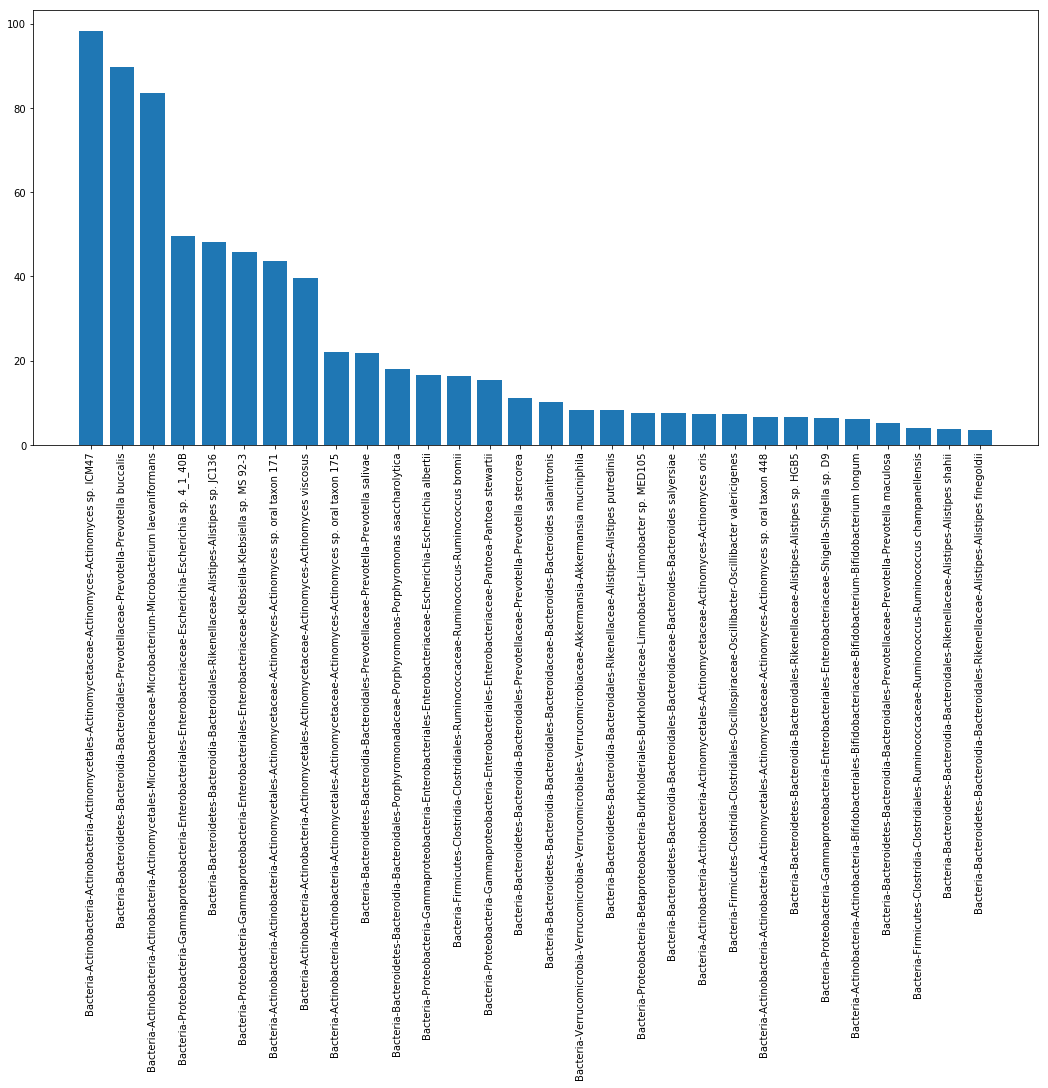

In [22]:
plt.figure(figsize=(18, 8))

probs = [prob for _, prob in important_specie_probabilities]
specie_names = [specie_name for specie_name, _ in important_specie_probabilities]

plt.bar(np.arange(len(probs[:30])), probs[:30])
plt.xticks(np.arange(len(probs[:30])), specie_names[:30], rotation=90);

In [25]:
important_species = [specie for specie, count in Counter(collection_of_species_list).most_common() if count >= 200]

df_subset = df_species.iloc[np.array(important_species),:]

total_abund = np.sum(df_subset.iloc[:,9:])

df_subset_normalized = df_subset.copy()
df_subset_normalized.iloc[:,9:] = df_subset_normalized.iloc[:,9:]/(total_abund)

np.min(df_subset_normalized.iloc[:,9:].values[df_subset_normalized.iloc[:,9:].values>0])


0.00084617709277727418

In [26]:
total_abund[total_abund>0].min()

8.7999999999999998e-05

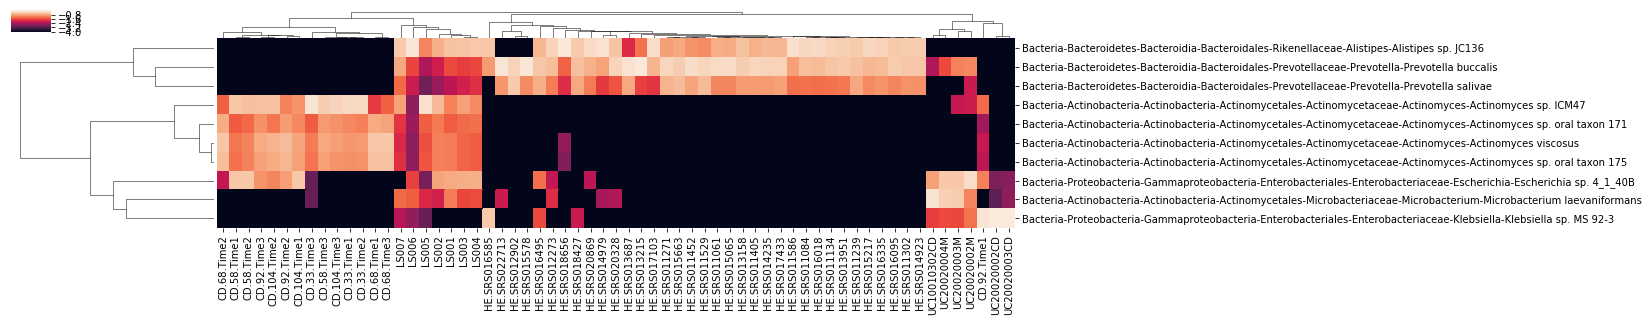

In [27]:
sns.clustermap(np.log10(1e-4+df_subset_normalized.iloc[:,9:]),
               figsize=(18, 4));

In [213]:
median_ratios = RatioComputer(df_subjects = df_species.iloc[:,9:], laplace_scale=1e-6)
cohort_cond_number = median_ratios.median_ratios_cond_number(laplace_scale_numerator=True, normalize=True)


In [214]:
df_species_medians = pd.concat([pd.DataFrame(median_ratios.LS_HE_median), 
                                pd.DataFrame(median_ratios.CD_HE_median),
                                pd.DataFrame(median_ratios.UC_HE_median)],axis = 1)

df_species_medians.columns = ["LS_HE", "CD_HE", "UC_HE"]


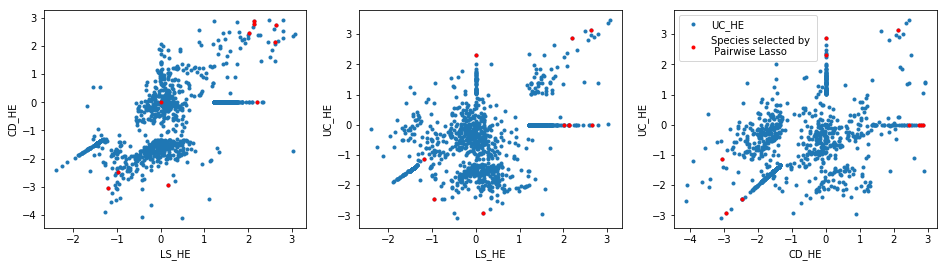

In [215]:
plt.figure(figsize=(16, 4))

for i, (x_axis,y_axis) in enumerate(itertools.combinations(df_species_medians.columns,2)):
    plt.subplot(1,3,i+1)
    # Use the 'hue' argument to provide a factor variable
    plt.plot(df_species_medians[x_axis], df_species_medians[y_axis], '.')
    plt.plot(df_species_medians.iloc[important_species,:][x_axis], 
             df_species_medians.iloc[important_species,:][y_axis], '.', label = "Species selected by \n Pairwise Lasso",
             color = "r")
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    

plt.legend()    

# KEGGs Pairwise Logistic Regression

In [83]:
X_keggs = df_keggs.iloc[:,2:].values.T

y_keggs = np.zeros(X_keggs.shape[0]) # 0 is healthy

y_keggs[np.where(df_keggs.iloc[:, 2:].columns.str.contains("LS"))[0]] = 1 # 1 is LS
y_keggs[np.where(df_keggs.iloc[:, 2:].columns.str.contains("CD"))[0]] = 2 # 2 is CD
y_keggs[np.where(df_keggs.iloc[:, 2:].columns.str.contains("UC"))[0]] = 3 # 3 is UC

In [84]:
X_keggs[X_keggs>0].min()

3.1125837891788104e-09

In [85]:
laplace_scale = 1e-9

In [86]:
clf = PairwiseLR(laplace_scale)

bg = BaggingClassifier(clf, 
                       bootstrap = True,
                       n_estimators=1000, 
                       n_jobs=-2, 
                       max_samples = 1.0)

In [87]:
%%time
bg.fit(X_keggs, y_keggs)

CPU times: user 8.36 s, sys: 10.9 s, total: 19.2 s
Wall time: 25min 11s


BaggingClassifier(base_estimator=PairwiseLR(laplace_scale=1e-09),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=1000, n_jobs=-2, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [88]:
collection_of_keggs = []
for estimator in bg.estimators_:
    collection_of_keggs.append(np.where(estimator.LR.coef_.squeeze() >0)[0])

In [90]:
collection_of_keggs_list = [kegg for keggs in collection_of_keggs for kegg in keggs]

kegg_frequency_counts = Counter(collection_of_keggs_list).most_common()

important_kegg_probabilities = [(df_keggs.kegg[kegg_index], 100*kegg_counts/1000) for kegg_index, kegg_counts in kegg_frequency_counts]




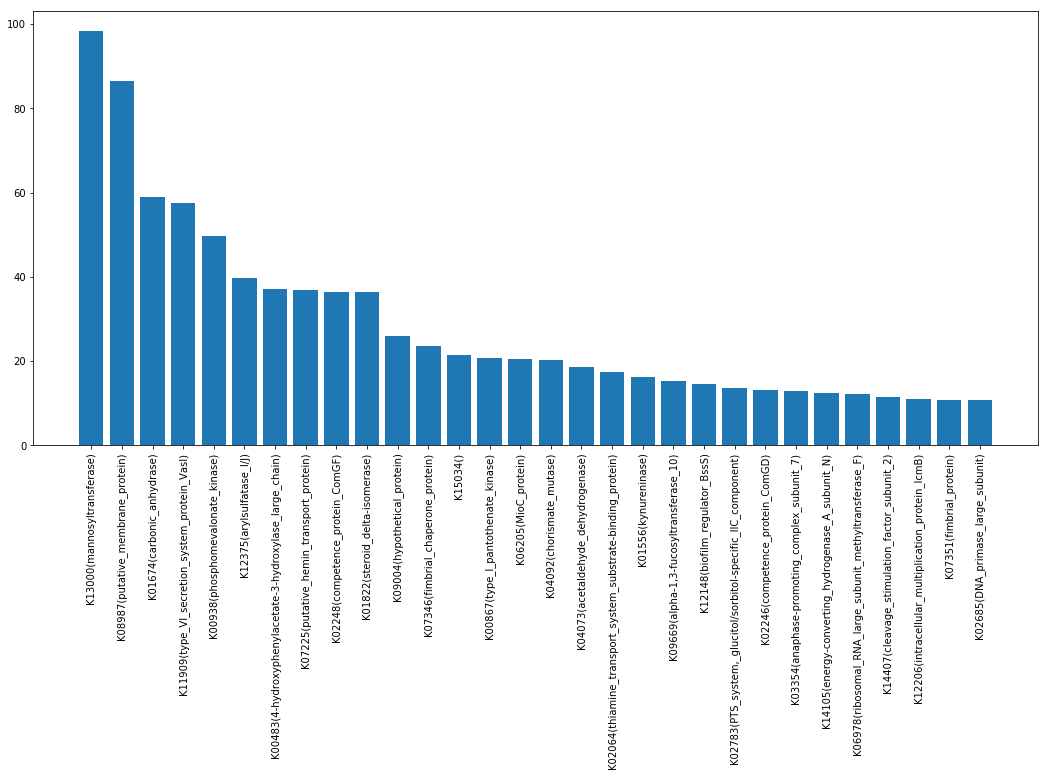

In [91]:
plt.figure(figsize=(18, 8))

probs = [prob for _, prob in important_kegg_probabilities]
kegg_names = [kegg_name for kegg_name, _ in important_kegg_probabilities]

plt.bar(np.arange(len(probs[:30])), probs[:30])
plt.xticks(np.arange(len(probs[:30])), kegg_names[:30], rotation=90);



In [186]:
important_keggs = [kegg for kegg, count in Counter(collection_of_keggs_list).most_common() if count >= 200]

df_subset = df_keggs.iloc[np.array(important_keggs),:]

total_abund = np.sum(df_subset.iloc[:,2:])

total_abund.min()

3.4434994895687186e-05

In [187]:
df_subset_normalized = df_subset.copy()
df_subset_normalized.iloc[:,2:] = df_subset_normalized.iloc[:,2:]/(total_abund)

np.min(df_subset_normalized.iloc[:,2:].values[df_subset_normalized.iloc[:,2:].values>0])

0.00017169119076036694

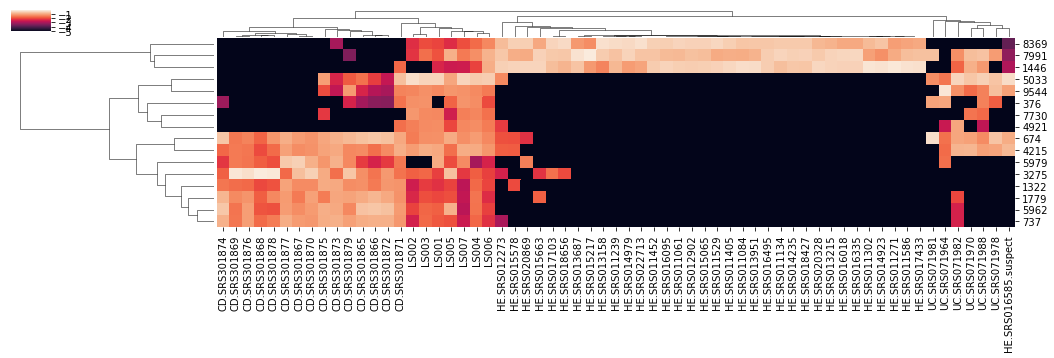

In [189]:
sns.clustermap(np.log10(1e-5+df_subset_normalized.iloc[:,2:]),
               figsize=(18, 4));

In [190]:
median_ratios = RatioComputer(df_subjects = df_keggs.iloc[:,2:], laplace_scale=1e-9)
cohort_cond_number = median_ratios.median_ratios_cond_number(laplace_scale_numerator=True, normalize=True)


In [191]:
df_keggs_medians = pd.concat([pd.DataFrame(median_ratios.LS_HE_median), 
                                pd.DataFrame(median_ratios.CD_HE_median),
                                pd.DataFrame(median_ratios.UC_HE_median)],axis = 1)

df_keggs_medians.columns = ["LS_HE", "CD_HE", "UC_HE"]


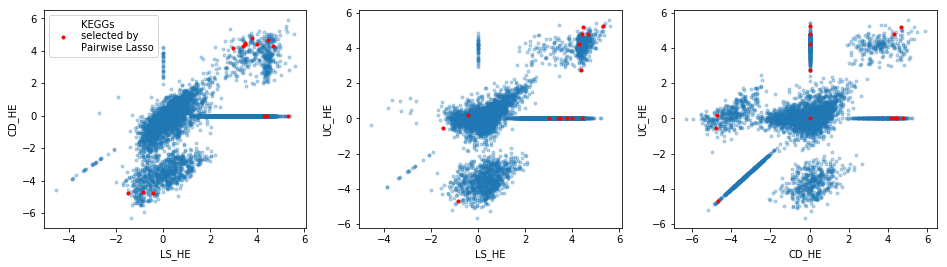

In [192]:
plt.figure(figsize=(16, 4))

for i, (x_axis,y_axis) in enumerate(itertools.combinations(df_keggs_medians.columns,2)):
    plt.subplot(1,3,i+1)
    # Use the 'hue' argument to provide a factor variable
    plt.plot(df_keggs_medians[x_axis], df_keggs_medians[y_axis], '.', alpha = .3, label = "")
    plt.plot(df_keggs_medians.iloc[important_keggs,:][x_axis], 
             df_keggs_medians.iloc[important_keggs,:][y_axis], '.', label = "KEGGs\nselected by\nPairwise Lasso",
             color = "r")
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    if i == 0:
        plt.legend();  
    



## save results

In [206]:
df_keggs.head()

,kegg,over.abundant.health.conf,LS001,LS002,LS003,LS004,LS005,LS006,LS007,CD.SRS301865,...,HE.SRS016335,HE.SRS016495,HE.SRS017103,HE.SRS017433,HE.SRS018427,HE.SRS018656,HE.SRS020328,HE.SRS020869,HE.SRS022713,HE.SRS016585.suspect
0,K00001(alcohol_dehydrogenase),0.366,0.005732,0.006140,0.006243,0.005962,0.008011,0.004744,0.005444,0.005043,...,0.002705,0.005025,0.003359,0.004281,0.003052,0.003625,0.002673,0.003999,0.003734,8.220359e-03
1,K00002(alcohol_dehydrogenase_(NADP+)),0.312,0.000382,0.000409,0.000610,0.000533,0.000313,0.000412,0.000390,0.001005,...,0.000461,0.000255,0.000071,0.000014,0.000248,0.000649,0.000151,0.000157,0.000000,4.812945e-07
2,K00003(homoserine_dehydrogenase),0.310,0.000855,0.001034,0.001125,0.001074,0.001224,0.000721,0.000786,0.001025,...,0.000195,0.001063,0.000249,0.000131,0.000351,0.000676,0.000430,0.000318,0.000050,1.209999e-06
3,"K00004((R,R)-butanediol_dehydrogenase_/_diacet...",0.192,0.000091,0.000106,0.000149,0.000116,0.000064,0.000084,0.000080,0.000016,...,0.000006,0.000025,0.000008,0.000008,0.000014,0.000039,0.000068,0.000010,0.000006,4.127393e-04
4,K00005(glycerol_dehydrogenase),0.004,0.000167,0.000236,0.000223,0.000203,0.000218,0.000144,0.000143,0.000166,...,0.000012,0.000427,0.000030,0.000004,0.000034,0.000036,0.000055,0.000065,0.000000,2.158647e-04


In [207]:
df_keggs_medians["kegg"] = df_keggs.kegg

In [208]:
df_keggs_medians["important_keggs"] = 0
df_keggs_medians.loc[important_keggs, "important_keggs"] = 1

In [209]:
df_keggs_medians.important_keggs.value_counts()

0    9996
1      16
Name: important_keggs, dtype: int64

In [216]:
df_species_medians["specie"] = df_species_medians.index

df_species_medians.reset_index(drop = True, inplace=True)

In [217]:
df_species_medians.head()

,LS_HE,CD_HE,UC_HE,specie
0,3.018256,-1.713132,0.014399,Archaea-Euryarchaeota-Methanobacteria-Methanob...
1,0.250507,-0.017575,-0.327434,Bacteria-Firmicutes-Clostridia-Clostridiales-C...
2,2.503851,1.621419,3.113955,Bacteria-Proteobacteria-Gammaproteobacteria-En...
3,0.160958,-0.220535,-0.482373,Bacteria-Firmicutes-Clostridia-Clostridiales-P...
4,-0.160857,-1.898158,0.002745,Bacteria-Fusobacteria-Fusobacteriia-Fusobacter...


In [218]:
df_species_medians["important_species"] = 0
df_species_medians.loc[important_species,"important_species"] = 1

In [221]:
df_species_medians.to_csv("../results/2018-07-26_important_species_ratio.csv", index = False)

In [212]:
df_keggs_medians.to_csv("../results/2018-07-26_important_keggs_ratio.csv", index = False)